In [65]:
import numpy as np
import random
import matplotlib.pyplot as plt

import gymnasium as gym

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical

In [21]:
env = gym.make('LunarLander-v2')

In [54]:
class Critic(nn.Module):
    def __init__(self, state_size):
        super().__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 1)
        self.init_weight()

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        value = self.fc2(x)
        return value

    def init_weight(self):
        for layer in self.modules():
            if isinstance(layer, nn.Linear):
                nn.init.kaiming_uniform_(layer.weight)
                nn.init.zeros_(layer.bias)



class Actor(nn.Module):
    def __init__(self, state_size, action_size):
        super().__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64,64)
        self.fc3 = nn.Linear(64, action_size)
        self.init_weight()

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.softmax(self.fc3(x), dim=-1)
        return x
    def init_weight(self):
        for layer in self.modules():
            if isinstance(layer, nn.Linear):
                nn.init.kaiming_uniform_(layer.weight)
                nn.init.zeros_(layer.bias)

critic_network = Critic(env.observation_space.shape[0])
actor_network = Actor(env.observation_space.shape[0], env.action_space.n)

actor_optimizer = optim.Adam(actor_network.parameters(), lr=0.001)
critic_optimizer = optim.Adam(critic_network.parameters(), lr=0.001)


In [ ]:
def select_action(actor, state):
    state = torch.tensor(state, dtype=torch.float32)
    dist = actor(state)
    sampler = Categorical(dist)
    action = sampler.sample()
    action_log_prob = sampler.log_prob(action)
    return action.item(), action_log_prob.reshape(-1)

In [61]:
gamma = 0.99
def calculate_losses(critic_network,action_log_prob, reward, state, next_state, done):
    state = torch.tensor(state, dtype=torch.float32)
    next_state = torch.tensor(next_state, dtype= torch.float32)
    value = critic_network(state)
    next_value = critic_network(next_state)
    td_target = reward + gamma * (1 - done) * next_value 
    td_error = td_target - value

    actor_loss = -1 * action_log_prob * td_error.detach()

    critic_loss = td_error ** 2
    return actor_loss, critic_loss

In [ ]:
def describe_episode(episode, actor_loss, critic_loss, episode_reward, step):
    print(f"Episode: {episode:3d}, Actor Loss: {actor_loss:.5f}, Critic Loss: {critic_loss:.5f}, Episode Reward: {episode_reward:.2f}, Steps: {step}")

In [67]:
result = []
for episode in range(1000):
    state, _ = env.reset()
    done = False
    episode_reward = 0
    step = 0

    while not done:
        step += 1
        action, action_log_prob = select_action(actor_network, state)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        episode_reward += reward
        
        actor_loss, critic_loss = calculate_losses(critic_network, action_log_prob, reward, state, next_state, done)
        actor_optimizer.zero_grad()
        actor_loss.backward()
        actor_optimizer.step()
        critic_optimizer.zero_grad()
        critic_loss.backward()
        critic_optimizer.step()
        state = next_state
    result.append(episode_reward)
    # describe_episode(episode, actor_loss.item(), critic_loss.item(), episode_reward, step)

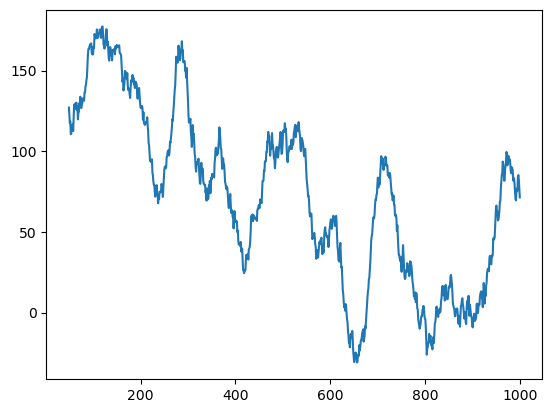

In [68]:
fig, ax = plt.subplots()

import pandas as pd
def smoothen(wind, result):
    result = pd.Series(result)
    result = result.rolling(window=wind).mean()
    return result.values
ax.plot(smoothen(50,result))
plt.show()